# Генетический алгоритм

In [1]:
import pandas as pd
import geopandas as gpd

matrix = pd.read_csv('matrix.csv')
schools = gpd.read_file('schools.geojson')
matrix = matrix.astype(int)

In [2]:
import numpy as np


def random_cities(mtx, num=10):
    cities = list(mtx.index)
    np.random.shuffle(cities)
    new_mtx = mtx.iloc[cities[:num], cities[:num]]
    mapping = {i: new_mtx.index.values[i] for i in range(0, new_mtx.shape[0])}
    return new_mtx, mapping

In [4]:
matrix_25, _ = random_cities(matrix, 25)
matrix_25.to_csv('matrix_25.csv', index=False)

matrix_50, _ = random_cities(matrix, 50)
matrix_50.to_csv('matrix_50.csv', index=False)

matrix_125, _ = random_cities(matrix, 125)
matrix_125.to_csv('matrix_125.csv', index=False)

matrix_250, _ = random_cities(matrix, 250)
matrix_250.to_csv('matrix_250.csv', index=False)


In [11]:
import array
import random
import numpy
import time
from deap import algorithms, base, creator, tools


def run_algorithm(params, matrix):
    pop_size, cx_prob, mut_prob, n_gen, indpb, tournsize = params
    distance_map = matrix.values.tolist()
    IND_SIZE = matrix.shape[0]

    def evalTSP(individual):
        distance = distance_map[individual[-1]][individual[0]]
        for gene1, gene2 in zip(individual[0:-1], individual[1:]):
            distance += distance_map[gene1][gene2]
        return distance,

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)

    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxPartialyMatched)
    toolbox.register("evaluate", evalTSP)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=indpb)
    toolbox.register("select", tools.selTournament, tournsize=tournsize)
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    _, logbook = algorithms.eaSimple(pop, toolbox, cx_prob, mut_prob, n_gen, halloffame=hof, stats=stats, verbose=False)

    current_best_fitness = hof[0].fitness.values[0]
    path = [city_index for city_index in hof[0]]

    return current_best_fitness, params, path, logbook

In [12]:
import itertools
import sys
import random
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

population_sizes = [280, 300, 320, 340, 360]
crossover_probs = [.3, .4, .5, .6, .7, .8]
mutation_probs = [.2, .3, .4, .5, .6]
generations = [200]
mutation_indpb = [.03, .04, .05, .06]
tournament_sizes = [4, 5, 6, 7, 8]

param_grid = list(
    itertools.product(population_sizes, crossover_probs, mutation_probs, generations, mutation_indpb, tournament_sizes))
random.seed(10)

results = Parallel(n_jobs=10)(
    delayed(run_algorithm)(params, matrix_25) for params in param_grid)  #n_jobs - кол-во ядер процессора

best_result = min(results, key=lambda x: x[0])

best_fitness = best_result[0]
best_params = best_result[1]
best_path = best_result[2]

print(f"Лучшие параметры: {best_params} с результатом: {best_fitness}")

Лучшие параметры: (280, 0.4, 0.2, 200, 0.05, 8) с результатом: 123072.0


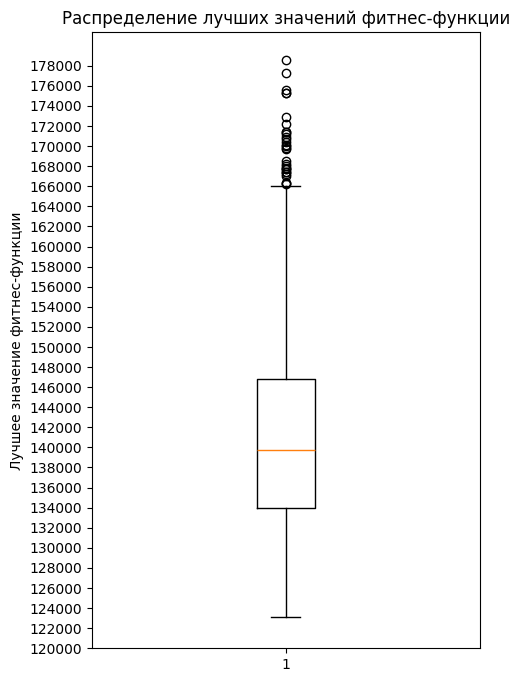

In [16]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(5, 8))
best_fitness_values = [result[0] for result in results]
plt.boxplot(best_fitness_values)
plt.yticks(np.arange(120000, 180000, 2000))
plt.title("Распределение лучших значений фитнес-функции")
plt.ylabel("Лучшее значение фитнес-функции")
plt.show()

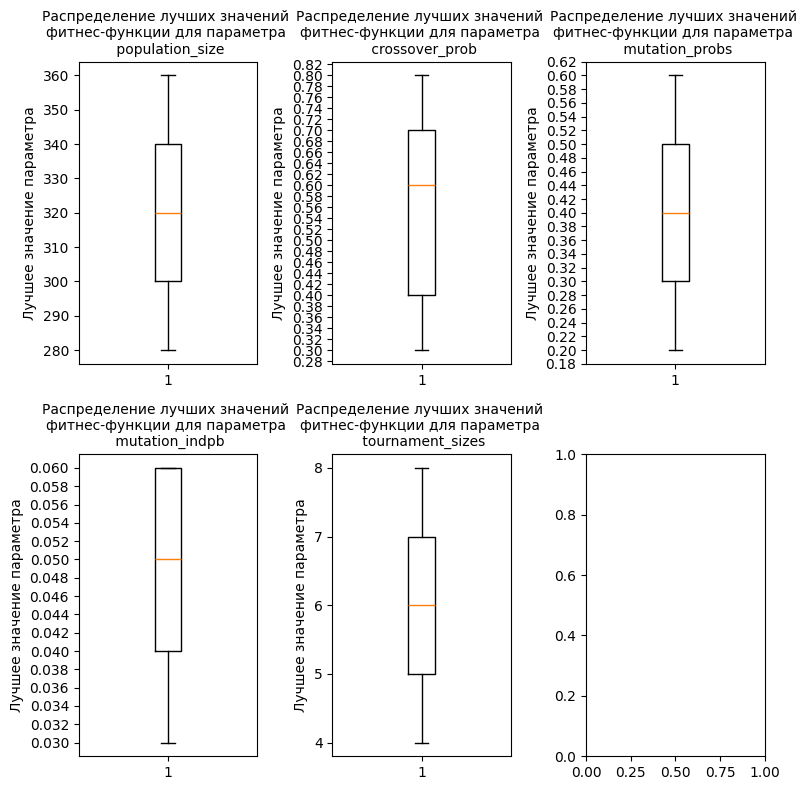

In [18]:

# Собираем лучшие значения фитнес-функции для каждого параметра
best_fitness_values = [(result[1][0], result[1][1], result[1][2], result[1][4], result[1][5],) for result in results if
                       120000 < result[0] < 148000]

# Создаем график "ящик с усами" для каждого параметра
fig, axs = plt.subplots(2, 3, figsize=(8, 8))

titles = ["population_size", "crossover_prob", "mutation_probs", "mutation_indpb", "tournament_sizes"]
locators = [10, .02, .02, .002, 1]

for i in range(len(best_fitness_values[0])):
    row = i // len(axs[0])
    col = i % len(axs[0])
    axs[row, col].boxplot([bfv[i] for bfv in best_fitness_values])
    axs[row, col].set_title(f"Распределение лучших значений \nфитнес-функции для параметра \n {titles[i]}",
                            fontdict={'fontsize': 10})
    axs[row, col].yaxis.set_major_locator(ticker.MultipleLocator(locators[i]))
    axs[row, col].set_ylabel("Лучшее значение параметра")
plt.tight_layout()
plt.show()


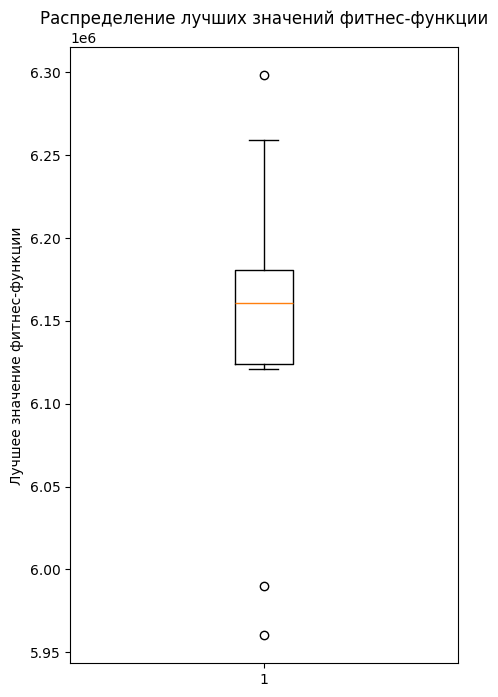

Лучший результат: 5960293.0


In [64]:
import itertools
import sys
import random
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

population_sizes = [500]
crossover_probs = [.6]
mutation_probs = [.4]
generations = [600 for x in range(0, 10)]
mutation_indpb = [.05]
tournament_sizes = [6]

param_grid = list(
    itertools.product(population_sizes, crossover_probs, mutation_probs, generations, mutation_indpb, tournament_sizes))

random.seed(10)

results = Parallel(n_jobs=10)(delayed(run_algorithm)(params, matrix) for params in param_grid)

best_result = min(results, key=lambda x: x[0])
best_fitness = best_result[0]
best_path = best_result[2]
best_fitness_values = [result[0] for result in results]
fig = plt.figure(figsize=(5, 8))
plt.boxplot(best_fitness_values)
plt.title("Распределение лучших значений фитнес-функции")
plt.ylabel("Лучшее значение фитнес-функции")
plt.show()
print(f"Лучший результат: {best_fitness}")

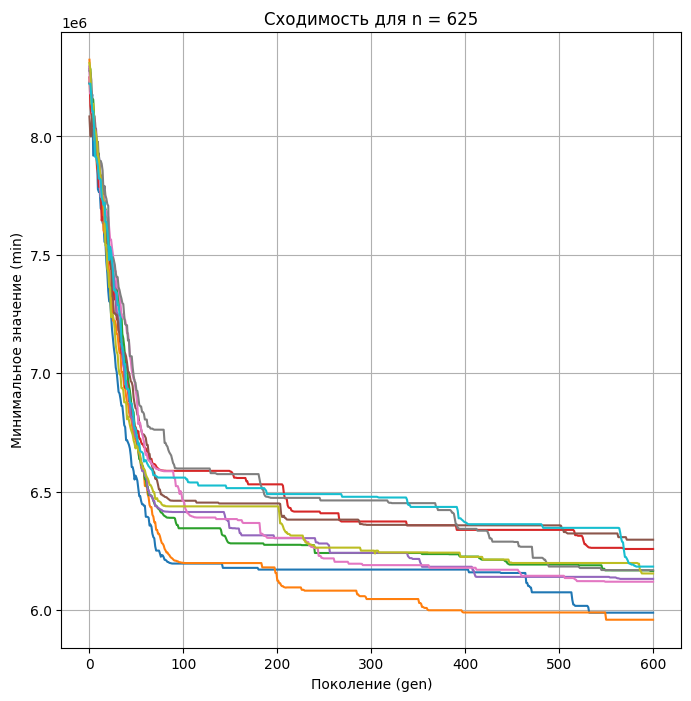

In [66]:
logs = [result[3] for result in results]
mins = [[y['min'] for y in x] for x in logs]
gens = [[y['gen'] for y in x] for x in logs]
plt.figure(figsize=(8, 8))
# Построй график
for mins, gens in zip(mins, gens):
    plt.plot(gens, mins)

# Настройка осей и заголовка

plt.xlabel('Поколение (gen)')
plt.ylabel('Минимальное значение (min)')
plt.title('Сходимость для n = 625')

# Отображение сетки
plt.grid(True)

# Отображение графика
plt.show()

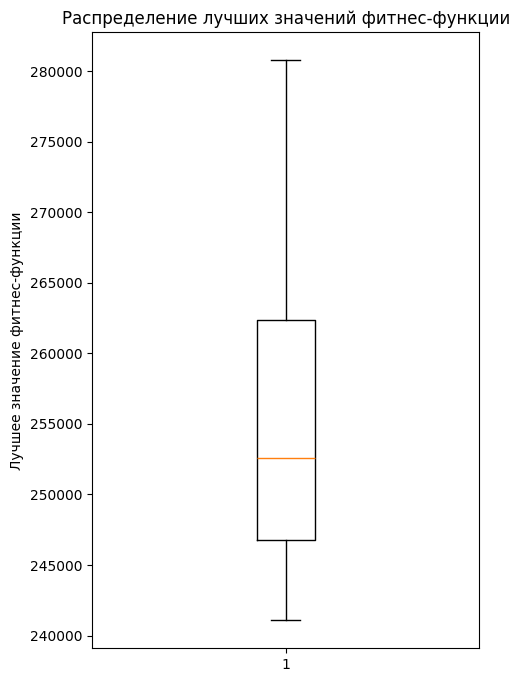

In [21]:
import random


def random_tsp(matrix, it):
    def evalTSP(individual):
        distance = matrix[individual[-1]][individual[0]]
        for gene1, gene2 in zip(individual[0:-1], individual[1:]):
            distance += matrix[gene1][gene2]
        return distance

    num_cities = len(matrix)
    best_len = float('inf')
    best_lens = []
    for _ in range(it):
        route = list(range(num_cities))
        random.shuffle(route)
        route_len = evalTSP(route)
        if route_len < best_len:
            best_lens.append(route_len)
            best_len = route_len
    return best_len, best_lens


best_lens_all = []
for _ in range(10):
    best_len, best_lens = random_tsp(matrix_25.values.tolist(), 300)
    best_lens_all.append(best_len)
fig = plt.figure(figsize=(5, 8))
plt.boxplot(best_lens_all)
plt.title("Распределение лучших значений фитнес-функции")
plt.ylabel("Лучшее значение фитнес-функции")
plt.show()

In [69]:
[int(x[0]) for x in results]

[5990037,
 5960293,
 6166117,
 6258890,
 6132683,
 6298080,
 6120698,
 6169384,
 6155505,
 6184532]

# ФРИДМАН  и НЕМЕНЬИ

In [71]:
from scipy import stats
import scikit_posthocs as sp
import numpy as np

data_group1 = [754526, 759352, 761057, 767540, 751248, 761846, 760645, 755524, 754276, 766498]  # Муравьи
data_group2 = [6325878, 6304710, 6376929, 6307172, 6216800, 6315007, 6331703, 6238883, 6393068, 6370506]  #Отжиг
data_group3 = [5990037, 5960293, 6166117, 6258890, 6132683, 6298080, 6120698, 6169384, 6155505, 6184532] #Генетика

# Conduct the Friedman Test
print(stats.friedmanchisquare(data_group1, data_group2, data_group3))
data = np.array([data_group1, data_group2, data_group3])

# Conduct the Nemenyi post-hoc test
sp.posthoc_nemenyi_friedman(data.T)

FriedmanchisquareResult(statistic=20.0, pvalue=4.539992976248486e-05)


,0,1,2
0,1.000000,0.001000,0.065303
1,0.001000,1.000000,0.065303
2,0.065303,0.065303,1.000000


In [ ]:
path = [mapping_1.get(city_index) for city_index in best_path]
import matplotlib.pyplot as plt

plt.figure(dpi=300)
for i in range(len(path) - 1):
    node1 = schools.iloc[path[i]]['geometry']
    node2 = schools.iloc[path[i + 1]]['geometry']
    plt.title("Лучший найденный путь")
    plt.plot(*zip((node1.x, node1.y), (node2.x, node2.y)), color='red')
    plt.scatter([node1.x, node2.x], [node1.y, node2.y], color='blue')